## Week 4

## Dataset
We will use Credit Card Data from book "Econometric Analysis".
The goal is to inspect the output of different evaluation metrics by creating a classification model (target column `card`). 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [5]:
data = 'wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv'

In [6]:
!wget $data -O data/AER_credit_card_data.csv

--2022-09-29 13:35:38--  http://wget/
Resolviendo wget (wget)... falló: nodename nor servname provided, or not known.
wget: no se pudo resolver la dirección del equipo “wget”
--2022-09-29 13:35:38--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolviendo raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Conectando con raw.githubusercontent.com (raw.githubusercontent.com)[185.199.109.133]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 73250 (72K) [text/plain]
Grabando a: “data/AER_credit_card_data.csv”

data/AER_credit_car 100%[===================>]  71.53K   433KB/s    en 0.2s    

2022-09-29 13:35:40 (433 KB/s) - “data/AER_credit_card_data.csv” guardado [73250/73250]

ACABADO --2022-09-29 13:35:40--
Tiempo total de reloj: 1.9s
Descargados: 1 ficheros, 72K en 0.2s (433 KB/s)


In [6]:
df = pd.read_csv('data/AER_credit_card_data.csv')

## Preparation

Create the target variable by mapping yes to 1 and no to 0.
Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1.

In [7]:
d = {'no': 0, 'yes': 1}
df['card'] = df['card'].map(d)

In [24]:
df.tail()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
1314,1,0,33.58333,4.566,0.002146,7.333333,yes,no,0,94,1,19
1315,0,5,23.91667,3.192,0.000376,0.000000,no,no,3,12,1,5
1316,1,0,40.58333,4.600,0.026513,101.298300,yes,no,2,1,1,2
1317,1,0,32.83333,3.700,0.008999,26.996670,no,yes,0,60,1,7
1318,1,0,48.25000,3.700,0.111619,344.157500,yes,no,2,2,1,0


In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

len (df), len(df_train), len(df_val), len(df_test)

(1319, 791, 264, 264)

In [9]:
from sklearn.metrics import roc_auc_score

In [10]:
roc_auc_col = ['reports', 'dependents', 'active', 'share']
dicc = {}

for col in roc_auc_col:
    roc_auc = roc_auc_score(y_train, df_train[col])
    if roc_auc < 0.5:
        roc_auc = roc_auc_score(y_train, -df_train[col])
    dicc[col] = roc_auc

In [11]:
max_dicc = list(zip(dicc.values(),dicc.keys()))
sorted(max_dicc)

[(0.5327757227773791, 'dependents'),
 (0.6043173411362006, 'active'),
 (0.7166629860689376, 'reports'),
 (0.989183643423692, 'share')]

Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- `share` X

## Training the model

From now on, use these columns only:

```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [12]:
features = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [13]:
#one-hot encoing
train_dict = df_train[features].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)

In [14]:
#Training logistic regression
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000)
model.fit(X_train, y_train)
        
val_dict = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dict)
        
model.predict_proba(X_val)
y_pred = model.predict_proba(X_val)[:,1]

In [15]:
roc_auc_score(y_val, y_pred).round(3)

0.995

In [16]:
scores = []

thresholds = np.arange(0, 1, 0.01)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [17]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

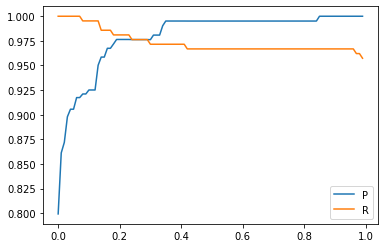

In [18]:
plt.plot(df_scores.threshold, df_scores['p'], label='P')
plt.plot(df_scores.threshold, df_scores['r'], label='R')
plt.legend()

At which threshold precision and recall curves intersect?

* 0.1
* 0.3 X
* 0.6
* 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [19]:
df_scores['f1'] = (2 * df_scores.p * df_scores.r)/ (df_scores.p + df_scores.r)

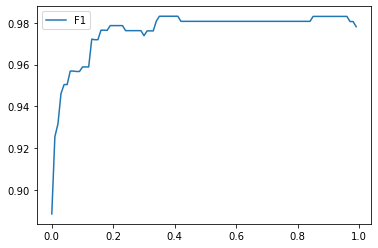

In [20]:
plt.plot(df_scores.threshold, df_scores['f1'], label='F1')
plt.legend()

In [136]:
df_scores[df_scores['f1'] == df_scores['f1'].max()]

,threshold,tp,fp,fn,tn,tpr,fpr,p,r,f1
35,0.35,205,1,6,52,0.971564,0.018868,0.995146,0.971564,0.983213
36,0.36,205,1,6,52,0.971564,0.018868,0.995146,0.971564,0.983213
37,0.37,205,1,6,52,0.971564,0.018868,0.995146,0.971564,0.983213
38,0.38,205,1,6,52,0.971564,0.018868,0.995146,0.971564,0.983213
39,0.39,205,1,6,52,0.971564,0.018868,0.995146,0.971564,0.983213
40,0.40,205,1,6,52,0.971564,0.018868,0.995146,0.971564,0.983213
41,0.41,205,1,6,52,0.971564,0.018868,0.995146,0.971564,0.983213


At which threshold F1 is maximal?

- 0.1
- 0.4 X
- 0.6
- 0.7

## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

In [21]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [22]:
def predict(df, dv, model):
    dicts = df[features].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [23]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [24]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.992 +- 0.006
C=0.01 0.995 +- 0.004
C=0.1 0.997 +- 0.003
C=0.5 0.996 +- 0.003
C=1 0.996 +- 0.003
C=5 0.996 +- 0.003
C=10 0.997 +- 0.003


How large is standard devidation of the AUC scores across different folds?

- 0.003 X
- 0.014
- 0.09
- 0.24

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [25]:
def train_new(df_train, y_train, C=1.0):
    dicts = df_train[features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [26]:
n_splits = 5

for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train_new(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.992 +- 0.006
C=0.1 0.995 +- 0.004
C=1 0.996 +- 0.003
C=10 0.996 +- 0.003


Which C leads to the best mean score?

- 0.01
- 0.1
- 1   
- 1   X
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C